In [14]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [15]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsF_0001.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(398,353)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.89931268, 4.07469926)>


In [16]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1V Reduced')
file1 = 'reduceducdF_0001.fits'
image1 = pf.getdata(file1)
file2 = 'reduceducdF_0002.fits'
image2 = pf.getdata(file2)
image = image1+image2

a = np.array(a)
b = np.array(b)
a = a-625
b = b-625
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[108.9000833  135.42385243 588.50281114 165.21160374 275.92725842
 205.38522042 656.55252815 537.62236776 708.04964155 604.40554041]
[563.96561317 667.66452063 548.44064121 487.05527883 512.33644574
 498.40606175 115.17254299 138.20087865 202.76536309 378.05547319]
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
--- --------- --------- --------- ... --- --------- --------- ----------
547 108.17909 563.18815 0.9056622 ...   0 2412.0402 183.51376 -5.6591716
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag   
--- --------- --------- ---------- ... --- --------- --------- ---------
661 134.93991 666.48244 0.88373726 ...   0 1737.8175 135.91207 -5.333145
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
530 583.59808 547.80354 0.98758653 ...   0 1982.0465 141.04145 -5.3733669
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    


In [17]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=2) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

In [18]:
print(mags)

[-10.265654044881604, -9.96272897055471, -10.002340829099108, -10.686657349802836, -11.766553686926166, -11.077124432034024, -10.713666088119975, -9.391853590640832, -9.845695560433231, -10.317671048809853]


[  0.91199554 -23.91055867]
[[ 9.65822445e-05 -1.38412767e-03]
 [-1.38412767e-03  1.98945339e-02]]
Beta: [  0.90024272 -23.71818663]
Beta Std Error: [0.02373062 0.35443805]
Beta Covariance: [[ 0.00022342 -0.00333537]
 [-0.00333537  0.04984082]]
Residual Variance: 2.520550986176771
Inverse Condition #: 0.012402241183169209
Reason(s) for Halting:
  Sum of squares convergence


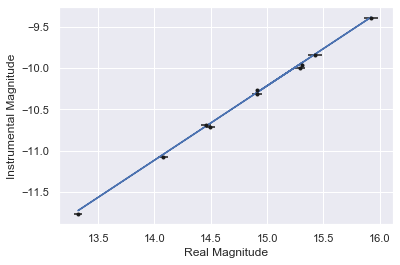

In [19]:
mags = np.array(mags)
realmag = [14.909,15.313,15.289,14.459,13.321,14.072,14.495,15.924,15.427,14.909]
realmag = np.array(realmag)
realmagerrors = [0.0032,0.0074,0.044,0.042,0.037,0.044,0.039,0.063,0.062,0.043]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [20]:
xref = 399
yref = 353

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
375 603.52375  376.8684 0.94358301 ...   0 2575.1708 189.86876 -5.6961338
349 397.52292 352.04423  0.7794377 ...   0  110687.8 9541.9392 -9.9490916


In [21]:
sourcemag = []
sourcemagerror = []
sourcemagerror = []
position = [(397.43,352.12)]
aperture = CircularAperture(position[0], r=2) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-14.511442925555663]


In [13]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

10.22695707767497 +/- 0.4771677384108483


In [22]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

10.22695707767497 +/- 0.4771677384108483


In [1]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z)

[[101.839311, 3.929904], [101.834507, 3.911874], [101.755641, 3.933425], [101.829614, 3.943406], [101.81025, 3.939188], [101.822584, 3.941496], [101.74449, 4.009061], [101.765208, 4.004846], [101.735356, 3.99388], [101.753151, 3.963151]]


In [2]:
x = [101.812093,101.806429,101.797486,101.771853,101.819136,101.810250,101.818790,101.818916,101.807737,101.788950]
y = [3.974229,3.963025,3.990697,3.942408,3.975548,3.939188,3.986519,3.946385,3.9309082,4.006325]
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z) 

[[101.839311, 3.929904], [101.834507, 3.911874], [101.755641, 3.933425], [101.829614, 3.943406], [101.81025, 3.939188], [101.822584, 3.941496], [101.74449, 4.009061], [101.765208, 4.004846], [101.735356, 3.99388], [101.753151, 3.963151], [101.812093, 3.974229], [101.806429, 3.963025], [101.797486, 3.990697], [101.771853, 3.942408], [101.819136, 3.975548], [101.81025, 3.939188], [101.81879, 3.986519], [101.818916, 3.946385], [101.807737, 3.9309082], [101.78895, 4.006325]]


In [5]:
x = [101.806429,101.797486,101.766053,101.766058,101.771853]
y = [3.963025,3.990697,3.978969,3.951486,3.942408]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z) 

[[101.806429, 3.963025], [101.797486, 3.990697], [101.766053, 3.978969], [101.766058, 3.951486], [101.771853, 3.942408]]


In [6]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z) 

[[101.839311, 3.929904], [101.834507, 3.911874], [101.755641, 3.933425], [101.829614, 3.943406], [101.81025, 3.939188], [101.822584, 3.941496], [101.74449, 4.009061], [101.765208, 4.004846], [101.735356, 3.99388], [101.753151, 3.963151]]


In [7]:
x = [101.812093,101.806429,101.797486,101.771853,101.819136,101.810250,101.818790,101.818916,101.807737,101.788950]
y = [3.974229,3.963025,3.990697,3.942408,3.975548,3.939188,3.986519,3.946385,3.9309082,4.006325]
z = []
for i,j in zip(x,y):
    k = [i,j]
    z.append(k)
print(z) 

[[101.812093, 3.974229], [101.806429, 3.963025], [101.797486, 3.990697], [101.771853, 3.942408], [101.819136, 3.975548], [101.81025, 3.939188], [101.81879, 3.986519], [101.818916, 3.946385], [101.807737, 3.9309082], [101.78895, 4.006325]]
